In [1]:
import pandas as pd
import geopandas as gpd
# import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS

LOAD DATA

In [9]:
#Load Massachusetts Trail Data
trails = gpd.read_file("../data/MA_State_Trails.geojson")
print("Trail Data Loaded!")
#Set global CRS
PROJECTION = trails.crs
# trails.plot()

Trail Data Loaded!


In [10]:
#Select by Name
def get_trail_by_name_helper(name):
    return trails[trails["name"] == name]

iNaturalist API

In [20]:
def api_get_trail_by_name(name: str):
    result = trails[trails["name"].str.lower() == name.lower()]
    if result.empty:
        return {"message": f"No trail found with name '{name}'."}
    
    # Drop all datetime columns
    datetime_cols = [col for col in result.columns if result[col].dtype.kind in "Mm"]  # M = datetime64, m = timedelta
    result = result.drop(columns=datetime_cols)

    return result.to_json()

api_get_trail_by_name("Norwottuck Rail Trail")

'{"type": "FeatureCollection", "features": [{"id": "9358", "type": "Feature", "properties": {"permanentidentifier": "{40735EB0-2B5A-4769-857A-D351CAA8485F}", "name": "Norwottuck Rail Trail", "namealternate": null, "trailnumber": null, "trailnumberalternate": null, "sourcefeatureid": null, "sourcedatasetid": "{0914CC36-E311-4F84-9D65-8E8EBE7ED090}", "sourcedatadecscription": "Massachusetts State Trails 05/2020", "sourceoriginator": "MassGIS (Bureau of Geographic Information)", "trailtype": "Terra Trail", "hikerpedestrian": null, "bicycle": null, "packsaddle": null, "atv": null, "motorcycle": null, "ohvover50inches": null, "snowshoe": null, "crosscountryski": null, "dogsled": null, "snowmobile": null, "nonmotorizedwatercraft": null, "motorizedwatercraft": null, "primarytrailmaintainer": "State", "nationaltraildesignation": null, "lengthmiles": 1.93377392, "networklength": 28137.052849170002, "globalid": "{7654B6B9-D73D-42D4-B0F8-31E718C73DFA}", "shape_Length": 0.03414400967143694}, "geom

Bounding Box, SW: (-72.62998167323978, 42.329292943867486) NE: (-72.46336871872809, 42.369992539971186)


0                 Coral Saucer
1               Dryad's Saddle
2            flocculose inkcap
3                 black locust
4      White-breasted Nuthatch
                ...           
195          Resinous Polypore
196         Woolly Alder Aphid
197        Isabella Tiger Moth
198                   Fallfish
199         Large Milkweed Bug
Name: species_guess, Length: 200, dtype: object

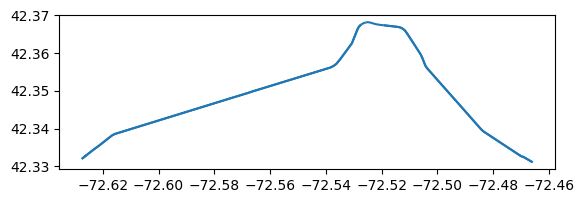

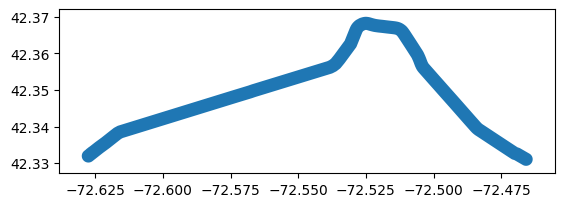

In [9]:
TRAIL_BUFFER = 200 #meters

#Select trail
trail = get_trail_by_name(trails, 'Norwottuck Rail Trail')
trail.plot()
#Add buffer:
trail = trail.to_crs(epsg=5070) #to metered projection
trail = gpd.GeoDataFrame(geometry=trail.buffer(TRAIL_BUFFER), crs=trail.crs)
trail = trail.dissolve()
trail = trail.to_crs(crs=PROJECTION) #back to original CRS
trail.plot()

#Get bounding box
SW_Lng, SW_Lat, NE_Lng, NE_Lat = trail.total_bounds
print(f"Bounding Box, SW: ({SW_Lng}, {SW_Lat}) NE: ({NE_Lng}, {NE_Lat})")

from datetime import datetime
curr_month = datetime.now().month
if curr_month == 1:
    last_month = 12
else:
    last_month = curr_month - 1
if curr_month == 12:
    next_month = 1
else:
    next_month = curr_month + 1

#Send url request
import requests


iNat_url = "https://api.inaturalist.org/v1/observations"
params = {
    "swlng": SW_Lng,
    "swlat": SW_Lat,
    "nelng": NE_Lng,
    "nelat": NE_Lat,      
    "quality_grade": "research",
    "per_page": 200,
    "page": 1,
    "month": [last_month, curr_month, last_month],        
    "year": [2022, 2023, 2024],     # last 3 years
    "order_by": "observed_on"
}

r = requests.get(iNat_url, params=params)
data = r.json()
observations = pd.json_normalize(data["results"])
species = observations["species_guess"]
display(species)

In [10]:
r.url

'https://api.inaturalist.org/v1/observations?swlng=-72.62998167323978&swlat=42.329292943867486&nelng=-72.46336871872809&nelat=42.369992539971186&quality_grade=research&per_page=200&page=1&month=9&month=10&month=9&year=2022&year=2023&year=2024&order_by=observed_on'

In [6]:
import requests

In [11]:
def get_species_by_trail(
    trail_name: str,
    current_month: int 
):
    TRAIL_BUFFER = 200 #meters

    #Select trail
    trail = get_trail_by_name_helper(trail_name)

    # trail.plot()
    #Add buffer:
    trail = trail.to_crs(epsg=5070) #to metered projection
    trail = gpd.GeoDataFrame(geometry=trail.buffer(TRAIL_BUFFER), crs=trail.crs)
    trail = trail.dissolve()
    trail = trail.to_crs(crs=PROJECTION) #back to original CRS
    # trail.plot()

    #Get bounding box
    SW_Lng, SW_Lat, NE_Lng, NE_Lat = trail.total_bounds
    # print(f"Bounding Box, SW: ({SW_Lng}, {SW_Lat}) NE: ({NE_Lng}, {NE_Lat})")

    # from datetime import datetime
    curr_month = current_month # a number
    if curr_month == 1:
        last_month = 12
    else:
        last_month = curr_month - 1
    if curr_month == 12:
        next_month = 1
    else:
        next_month = curr_month + 1

    iNat_url = "https://api.inaturalist.org/v1/observations"
    params = {
        "swlng": SW_Lng,
        "swlat": SW_Lat,
        "nelng": NE_Lng,
        "nelat": NE_Lat,      
        "quality_grade": "research",
        "per_page": 200,
        "page": 1,
        "month": [last_month, curr_month, last_month],        
        "year": [2022, 2023, 2024],     # last 3 years
        "order_by": "observed_on"
    }

    r = requests.get(iNat_url, params=params)
    
    data = r.json()
    observations = pd.json_normalize(data["results"])
    species = observations["species_guess"]
    # display(species)    
    return species.to_json()



In [12]:
get_species_by_trail("Norwottuck Rail Trail", 12                    )


'{"0":"intermediate wood fern","1":"prickly tree-clubmoss","2":"Dark-eyed Junco","3":"Song Sparrow","4":"American Tree Sparrow","5":"American Tree Sparrow","6":"Northern Cardinal","7":"winged euonymus","8":"black locust","9":"common milkweed","10":"Northern Harrier","11":"Merlin","12":"Song Sparrow","13":"Song Sparrow","14":"Song Sparrow","15":"Song Sparrow","16":"Red-tailed Hawk","17":"Savannah Sparrow","18":"boxelder","19":"American beech","20":"Northern Harrier","21":"Savannah Sparrow","22":"Northern Harrier","23":"Canada Goose","24":"Common Merganser","25":"Common Merganser","26":"Red-tailed Hawk","27":"Bobcat","28":"Domestic Cat","29":"Savannah Sparrow","30":"black locust","31":"House Finch","32":"Dark-eyed Junco","33":"House Finch","34":"Song Sparrow","35":"Northern Cardinal","36":"Merlin","37":"Merlin","38":"European Starling","39":"Bobcat","40":"Pileated Woodpecker","41":"sensitive fern","42":"eastern white pine","43":"Barred Owl","44":"border privet","45":"Eastern Gray Squirre

In [13]:
def search_trails_by_name(
    q: str
):
    """Return a list of trails whose names contain the search string."""
    # Case-insensitive substring search
    matches = trails[trails["name"].str.contains(q, case=False, na=False)]

    if matches.empty:
        return {"message": f"No trails found matching '{q}'."}

    # Drop datetime columns (avoid serialization issues)
    datetime_cols = [col for col in matches.columns if matches[col].dtype.kind in "Mm"]
    matches = matches.drop(columns=datetime_cols)

    # Simplify result — return only key info
    simplified = matches[["name", "geometry"]].copy()
    simplified["geometry"] = simplified["geometry"].astype(str)

    # Convert to list of dicts
    results_list = simplified.to_dict(orient="records")

    return {"count": len(results_list), "results": results_list}

In [15]:
search_trails_by_name("Frost")

C:\Users\nkcwa\AppData\Local\Temp\ipykernel_36904\439363689.py:17: UserWarning: Geometry column does not contain geometry.
  simplified["geometry"] = simplified["geometry"].astype(str)


{'count': 55,
 'results': [{'name': 'Frost Pocket Path',
   'geometry': 'LINESTRING (-70.68551 41.837353, -70.685816 41.83722, -70.685927 41.837187, -70.686027 41.837173, -70.686107 41.837174, -70.686222 41.837195, -70.686317 41.837224, -70.687062 41.837569, -70.687123 41.837584, -70.687176 41.837579, -70.68723 41.837559, -70.687393 41.837457)'},
  {'name': 'Frost Pocket Path',
   'geometry': 'LINESTRING (-70.682477 41.840292, -70.68262 41.840037, -70.682873 41.839558, -70.682904 41.839524, -70.682966 41.839487, -70.683043 41.839468, -70.683111 41.839474, -70.68337 41.839581, -70.68345 41.839605, -70.683561 41.839617, -70.683721 41.839615, -70.683824 41.839608, -70.683915 41.839587, -70.683997 41.839554, -70.684054 41.839511, -70.684086 41.839461, -70.684091 41.839398, -70.684072 41.839355, -70.683989 41.839277, -70.683959 41.839228, -70.683941 41.839177, -70.683938 41.839125, -70.683958 41.839065, -70.683985 41.839031, -70.684054 41.83898, -70.68442 41.838768, -70.684625 41.838622, -7

In [27]:
fpp = api_get_trail_by_name("Frost Pocket Path")


In [18]:
fpp["features"]

KeyError: 'features'